# 3. Modeling 

In this section, we will compare and evaluate two machine learning models: Logistic Regression (Log Reg) and Random Forest. While both models are commonly used for classification tasks, they differ significantly in their approach and complexity. We will begin by focusing on Random Forest, but we will also include Logistic Regression as a baseline model.


In [1]:
# Libraries for data manipulation and matrices
import numpy as np          # For working with numerical arrays
import pandas as pd         # For handling data in DataFrame format

# Libraries for visualization
import matplotlib.pyplot as plt  # For creating plots and visualizations
import seaborn as sns

# Tools for working with sparse matrices (common in text data)
from scipy.sparse import hstack, csr_matrix  # To combine sparse matrices and create compressed sparse row matrices

# For splitting the dataset, tuning hyperparameters, and creating pipelines
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.pipeline import Pipeline  

# Classification models
from sklearn.naive_bayes import MultinomialNB        # Naive Bayes classifier for text
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.ensemble import RandomForestClassifier  # Random Forests
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

# Metrics to evaluate model performance
from sklearn.metrics import classification_report, accuracy_score  

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # To convert text into numerical features

# Preprocessing for scaling features
from sklearn.preprocessing import StandardScaler  # For feature scaling

df = pd.read_csv('Datasets/post_reddit_eda.csv')


In [2]:
df.dtypes

title                            object
self_text                        object
type_user                        object
Description                      object
subreddit                        object
num_comments                      int64
score                             int64
upvote_ratio                    float64
author                           object
media                            object
has_self_text                     int64
has_author                        int64
emojis_title                     object
emojis_self_text                 object
clean_title                      object
clean_self_text                  object
has_emojis_self_text              int64
has_emojis_title                  int64
full_text                        object
word_count_title                  int64
word_count_self_text              int64
sentiment_title                  object
sentiment_self_text              object
sentiment_title_pos             float64
sentiment_title_neg             float64


In [3]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),max_features=1000, stop_words='english')  # Limitar a 5000 palabras más importantes

# Paso 2: Vectorizar las columnas 'clean_title' y 'clean_self_text' juntas
# Aquí combinamos ambos campos de texto para crear una representación completa del post
df['full_text']
df.dropna(subset=['full_text'],inplace=True)
df['total_word_count'] = df['word_count_title'] + df['word_count_self_text']

X_tfidf = vectorizer.fit_transform(df['full_text'].fillna(''))
X_count_title = df['word_count_title'].values.reshape(-1, 1)
X_count_self_text = df['word_count_self_text'].values.reshape(-1, 1)


# Extraer la columna de sentimiento (ya es un valor numérico, no necesitas más transformación)
X_sentiment = df['sentiment_self_text_neu'].values.reshape(-1, 1)
X_media = df['has_media'].values.reshape(-1, 1)

# Extraer la columna 'media' (es binaria, así que la tratamos como una característica más)
#X_total = df['total_word_count'].values.reshape(-1, 1)
X_score = df['score'].values.reshape(-1, 1)

X_full = hstack([X_tfidf, X_sentiment,X_media,X_score])  # Aquí unimos todo


In [4]:

Z=csr_matrix(X_full)

# Aplicar estandarización
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(Z)


In [5]:
#X = vectorizer.fit_transform(df['full_text'])

# Paso 3: Definir el objetivo
y = df['subreddit']  # Si tienes un objetivo como "platform" (DoorDash, UberEats, Unknown)
#y = [0 if x == 'UberEATS' else 1 for x in y ]

# Paso 4: Dividir los datos en conjunto de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, stratify=y,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, stratify=y,random_state=42)

# Paso 5: Entrenar el modelo (usaremos Random Forest como ejemplo)
model = RandomForestClassifier(n_estimators=1000, random_state=42, )
model.fit(X_train, y_train)

# Paso 6: Evaluar el modelo
y_pred = model.predict(X_test)
print("Random Forest Results:")
# Paso 7: Imprimir el reporte de clasificación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Results:
Accuracy: 0.8223443223443223
Classification Report:
               precision    recall  f1-score   support

    UberEATS       0.85      0.72      0.78       237
    doordash       0.81      0.90      0.85       309

    accuracy                           0.82       546
   macro avg       0.83      0.81      0.81       546
weighted avg       0.83      0.82      0.82       546



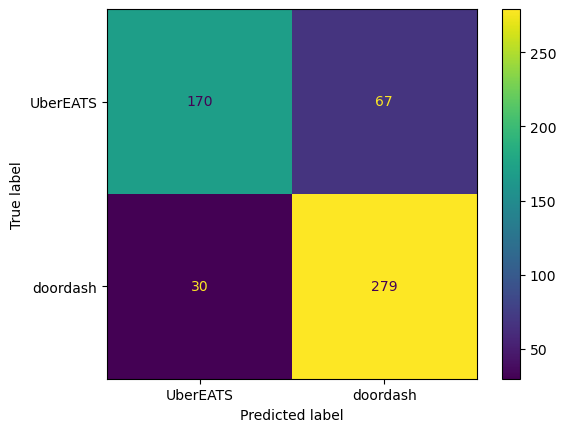

In [6]:
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Area Under the ROC Curve (AUC): 0.8101060997091476


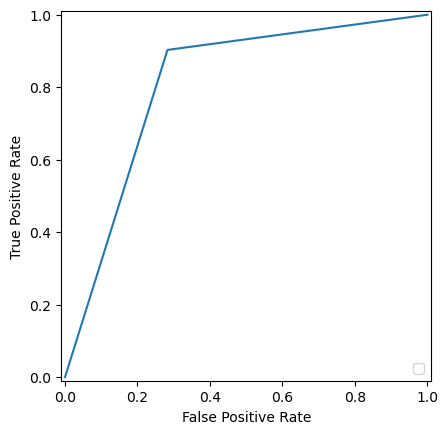

In [7]:

y_test = [1 if x == 'doordash' else 0 for x in y_test]
y_pred_0 = [1 if x == 'doordash' else 0 for x in y_pred]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_0, pos_label=1)  # Assuming '1' is the positive class
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_0)
print(f"Area Under the ROC Curve (AUC): {auc}")

In [8]:

# Assuming vectorizer is your TF-IDF vectorizer (e.g., TfidfVectorizer)
tfidf_features = vectorizer.get_feature_names_out()

# Additional features
additional_features = ['sentiment_self_text_neu', 'has_media', 'score']  # Adjust according to your actual feature names


# Assuming you have a model that provides feature importances, such as a tree-based classifier
# For example: importances = model.feature_importances_ 
importances = model.feature_importances_  # Replace this with the actual importances from your model

# Create the full list of features
all_features = np.concatenate([tfidf_features, additional_features])

# Create the DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Sort by importance (in descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print("Top 10 Features by Importance:")
print(feature_importance_df.head(10))

# Sort by importance in ascending order (if needed)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Print the bottom 10 features
print("Bottom 10 Features by Importance:")
print(feature_importance_df.head(10))


Top 10 Features by Importance:
        Feature  Importance
909        uber    0.099446
246    doordash    0.047463
273        eats    0.028380
912   uber eats    0.027837
188      dasher    0.026934
916    ubereats    0.026621
1002      score    0.026043
186        dash    0.024582
256      driver    0.015331
1001  has_media    0.014765
Bottom 10 Features by Importance:
        Feature  Importance
787      silver    0.000015
946   walgreens    0.000019
85        black    0.000020
722      repeat    0.000027
305         eye    0.000030
433      inform    0.000032
669    priority    0.000034
228  disconnect    0.000034
813    standard    0.000044
557    neighbor    0.000044


In [10]:
# Entrenar un modelo de regresión logística
y_train_0 = [1 if x == 'doordash' else 0 for x in y_train]

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train_0)

# Hacer predicciones y evaluar el modelo de regresión logística
y_pred_logreg = logreg_model.predict(X_test)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred_logreg))

Logistic Regression - Accuracy: 0.8131868131868132
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.69      0.76       237
           1       0.79      0.91      0.85       309

    accuracy                           0.81       546
   macro avg       0.82      0.80      0.80       546
weighted avg       0.82      0.81      0.81       546



In [12]:
coefficients = logreg_model.coef_.flatten()

# Obtener las características del tfidf_vectorizer
tfidf_features = vectorizer.get_feature_names_out()

# Obtener el número de características adicionales (X_media y X_total)
additional_features = ['sentiment_self_text_neu', 'has_media', 'score']  # Ajusta esto según los nombres de las características

# Crear un conjunto final de características, que incluye tanto las del TF-IDF como las adicionales
all_features = np.concatenate([tfidf_features, additional_features])

# Verificar que el número de coeficientes y el número de características coincidan
print("Número de coeficientes:", len(coefficients))
print("Número de características:", len(all_features))

# Asegúrate de que las longitudes coincidan
if len(coefficients) == len(all_features):
    # Crear un dataframe con las características y sus coeficientes
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients
    })

    # Ordenar por la importancia (valor absoluto del coeficiente)
    feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
    feature_importance_sorted = feature_importance.sort_values(by='AbsCoefficient', ascending=False)

    # Mostrar las características más importantes
    print(feature_importance_sorted.head(10))
    feature_importance_sorted = feature_importance.sort_values(by='AbsCoefficient', ascending=True)

    # Mostrar las características más importantes
    print(feature_importance_sorted.head(10))    
else:
    print(f"Mismatch: Coefficients length: {len(coefficients)}, Features length: {len(all_features)}")

Número de coeficientes: 1003
Número de características: 1003
       Feature  Coefficient  AbsCoefficient
909       uber    -7.459577        7.459577
246   doordash     6.832378        6.832378
188     dasher     4.824755        4.824755
186       dash     4.442945        4.442945
916   ubereats    -4.164018        4.164018
189    dashers     3.147122        3.147122
192         dd     2.914421        2.914421
273       eats    -2.547109        2.547109
912  uber eats    -2.473237        2.473237
256     driver    -2.326592        2.326592
               Feature  Coefficient  AbsCoefficient
774                set    -0.000230        0.000230
36    apartment number    -0.000282        0.000282
637           personal     0.000327        0.000327
688            quickly     0.000458        0.000458
1002             score     0.000960        0.000960
863             texted     0.002121        0.002121
687              quick    -0.002533        0.002533
965            weekend     0.002543    

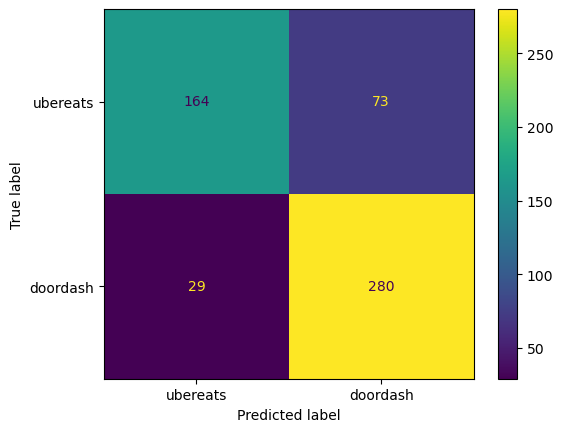

In [24]:
y_test_again = ['doordash' if x == 1 else 'ubereats' for x in y_test]

class_labels = ['ubereats', 'doordash']

_ = ConfusionMatrixDisplay.from_estimator(logreg_model, X_test, y_test, display_labels=class_labels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


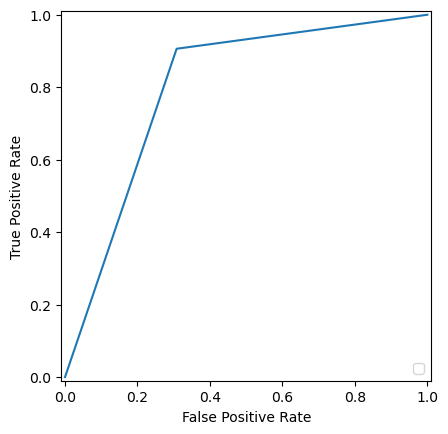

In [15]:
# Calcular la curva ROC

fpr, tpr, _ = roc_curve(y_test, y_pred_logreg, pos_label=logreg_model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot();